### Data Preparation

Data preparation: Now keeps only tail data and normalizes HiggsM values for conditioning.

Model: ConditionalMLP now accepts multiple inputs based on the number of features:

The HiggsM conditioning information is projected and added to the network, allowing the model to learn how the velocity field varies with HiggsM.

Training: Now passes the corresponding HiggsM value for each sample during training.

Sampling (cell 12): Samples across the entire HiggsM range including the pole region. The model uses learned patterns from tail data to extrapolate predictions into the pole region where it has no direct training data.

In [1]:
import tqdm
import math
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Set device - use CUDA if available, otherwise CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

raw_df = pd.read_hdf('data_files/new_Input_NonResonant_yy_25th_January2026.h5', key='VBF_Polarisation_Tree')

# Define bounds
lower_bound = 115000
upper_bound = 135000

mask1 = raw_df['HiggsM'] > upper_bound
mask2 = raw_df['HiggsM'] < lower_bound

# Applying the bounds to the raw data for the other features
trimmed_df = raw_df[mask1 | mask2]

# Save the trimmed DataFrame to a CSV file for inspection
# Filter out unnecessary columns and save the relevant features along with HiggsM and Frequency
# trimmed_df.to_csv('data_dump/trimmed_data.csv')
features = ['DNN_score', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1']
features_array = trimmed_df[features].to_numpy()
num_features = features_array.shape[1]
# print(features_array.shape)
# print(features_array[:5, :])

# Array of HiggsM values for training
HiggsM_array = trimmed_df['HiggsM'].to_numpy()
# print(HiggsM_array.shape)
# print(HiggsM_array[:5])

Using device: cpu


In [2]:
from sklearn.preprocessing import MinMaxScaler


# Normalise function
# Un-nomralise later using sampled_points_original = scaler.inverse_transform(sampled_points_normalized)
scaler_features = MinMaxScaler()
scaler_HiggsM = MinMaxScaler()

# Normalise features and HiggsM separately
features_normalised = scaler_features.fit_transform(features_array)
HiggsM_normalised = scaler_HiggsM.fit_transform(HiggsM_array.reshape(-1, 1))

### Random noise data points to start with, this is the initial distribution p0(x0), original code used random noise, replace with the Higgs tail data.


## Model

### The multi-feature model has input channels based on the number of features

In [3]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class ConditionalMLP(nn.Module):
    def __init__(self, channels_data=num_features, layers=5, channels=512, channels_t=512, channels_cond=128, cond_dim=1):
        super().__init__()
        self.channels_t = channels_t
        self.channels_cond = channels_cond
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)

        # Condition (HiggsM) projection
        self.cond_projection = nn.Linear(cond_dim, channels_cond)
        self.cond_to_channels = nn.Linear(channels_cond, channels)

        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t, cond):
        # x: [batch, channels_data] (features)
        # t: [batch] (time)
        # cond: [batch, cond_dim] (HiggsM normalized)
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        cond = self.cond_projection(cond)  # [batch, channels_cond]
        cond = self.cond_to_channels(cond)  # [batch, channels]
        # Combine: data + time + condition
        x = x + t + cond
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [4]:
model = ConditionalMLP(
    channels_data=num_features,
    layers=5,
    channels=512,
    channels_cond=128,
    cond_dim=1,
    )
model = model.to(device)  # Move model to GPU/CPU
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

## Training

### Again this shouldn't change much for now aside from the distributions being used

In [5]:
# Separate HiggsM and Frequency data (both normalized)
features_data = torch.Tensor(features_normalised).to(device)  # [N, 8] - normalized to [0, 1]
higgsM_data = torch.Tensor(HiggsM_normalised).to(device)  # [N, 1] - normalized to [0, 1]

training_steps = 100000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    # Sample random indices
    idx = torch.randint(features_data.size(0), (batch_size,))
    # Get frequency data (x1 is the target tail frequency)
    x1 = features_data[idx]  # [batch, 8]
    # Get corresponding HiggsM conditioning values
    cond = higgsM_data[idx]  # [batch, 1]

    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0)).to(device)
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1

    # Model prediction (now conditioned on HiggsM)
    pred = model(xt, t, cond)

    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())  


100%|██████████| 100000/100000 [59:00<00:00, 28.25it/s, loss=0.161]  


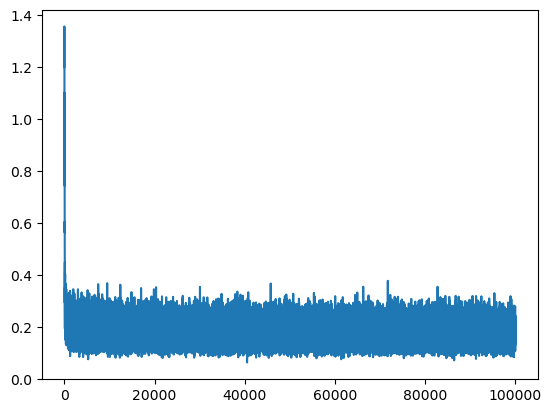

In [6]:
plt.plot(losses)

## Sampling

### Same thing as Model and Training section

In [7]:
torch.manual_seed(42)
model.eval().requires_grad_(False)

"""
# Gives the shape (number of points) of the pole region data and also the true points in the pole region
true_pole_df = raw_df[~(mask1 | mask2)]
true_points = true_pole_df.to_numpy()

# Sample across the full HiggsM range (tails + pole region)
# Ensures that the number of samples in the pole region matches the number of true points
num_samples_per_region = true_points.shape[0]
"""

# Randomly take a sample of points from the pole region and tails to reduce memory load when sampling
sample_size = 10000
true_pole_df = raw_df[~(mask1 | mask2)]
true_pole_samples = true_pole_df.sample(n=sample_size, random_state=42)
tail1_samples = raw_df[mask1].sample(n=sample_size, random_state=42)
tail2_samples = raw_df[mask2].sample(n=sample_size, random_state=42)

Higgs_pole_samples = true_pole_samples['HiggsM'].to_numpy()
Higgs_tail1_samples = tail1_samples['HiggsM'].to_numpy()
Higgs_tail2_samples = tail2_samples['HiggsM'].to_numpy()
HiggsM_sample = np.concatenate([Higgs_tail1_samples, Higgs_pole_samples, Higgs_tail2_samples])
HiggsM_sample_norm = scaler_HiggsM.transform(HiggsM_sample.reshape(-1, 1)).flatten()


steps = 1000

# Initialize noise on device (same feature dimension as training data)
xt = torch.randn(len(HiggsM_sample), features_array.shape[1], device=device)
cond = torch.Tensor(HiggsM_sample_norm[:, None]).to(device)

# Sampling process
plot_every = 50
for step, t in enumerate(torch.linspace(0, 1, steps), start=1):
    with torch.no_grad():
        pred = model(xt, t.expand(xt.size(0)).to(device), cond)
    xt = xt + (1 / steps) * pred
    if step % plot_every == 0:
        print(f"{int(step/plot_every)}x50 steps done")
        xt_denorm = xt.detach().cpu().numpy()

model.train().requires_grad_(True)
print("Done")

1x50 steps done
2x50 steps done
3x50 steps done
4x50 steps done
5x50 steps done
6x50 steps done
7x50 steps done
8x50 steps done
9x50 steps done
10x50 steps done
11x50 steps done
12x50 steps done
13x50 steps done
14x50 steps done
15x50 steps done
16x50 steps done
17x50 steps done
18x50 steps done
19x50 steps done
20x50 steps done
Done


### Taking output data and comparing it to true data by saving both as a csv file

In [8]:
print(HiggsM_sample_norm)

[0.92365515 0.6174158  0.6009394  ... 0.11992276 0.04994655 0.00550652]


In [9]:
# Denormalising the values produced by the model
HiggsM_denorm = scaler_HiggsM.inverse_transform(HiggsM_sample_norm.reshape(-1, 1)).flatten()
features_denorm = scaler_features.inverse_transform(xt.detach().cpu().numpy())

pred_points = pd.DataFrame({'HiggsM': HiggsM_denorm,
                            'DNN_score': features_denorm[:, 0],
                            'DPhi_jj': features_denorm[:, 1],
                            'Eta_jj': features_denorm[:, 2], 
                            'M_jj': features_denorm[:, 3],
                            'Njets': features_denorm[:, 4],
                            'OO1': features_denorm[:, 5],
                            })

# Constructing the pole region data for both the predicted and true data
lower_bound = 115000
upper_bound = 135000
pred_points_pole = pred_points[(pred_points['HiggsM'] >= lower_bound) & (pred_points['HiggsM'] <= upper_bound)]
true_points_pole = true_pole_samples[['HiggsM', 'DNN_score', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1']]

# Saving data to csv for comparison
csv1 = pd.DataFrame(pred_points_pole, columns=['HiggsM', 'DNN_score', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1'])
csv2 = pd.DataFrame(true_points_pole, columns=['HiggsM', 'DNN_score', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1'])
csv1.to_csv('data_dump/multi_predicted_pole_region.csv', index=False)
csv2.to_csv('data_dump/multi_true_pole_region.csv', index=False)
# print(pred_points_pole)

## KL Divergence calculation to assess quality of the model


In [10]:
# Convert true_points_pole and pred_points_pole to a numpy array
pred_points_array = pred_points_pole.to_numpy()
true_points_array = true_points_pole.to_numpy()
print(true_points_array.shape, pred_points_array.shape)

# Ensuring that both arrays have the same shape for KL Divergence calculation by trimming both ends
counter = 0
if pred_points_array.shape > true_points_array.shape:
    while pred_points_array.shape != true_points_array.shape:
        if counter % 2 == 0: 
            pred_points_array = np.delete(pred_points_array, -1, axis=0)
            counter += 1
        else:
            pred_points_array = np.delete(pred_points_array, 0, axis=0)
        counter += 1

elif pred_points_array.shape < true_points_array.shape:
    while pred_points_array.shape != true_points_array.shape:
        if counter % 2 == 0: 
            true_points_array = np.delete(true_points_array, -1, axis=0)
            counter += 1
        else:
            true_points_array = np.delete(true_points_array, 0, axis=0)
            counter += 1

# Implement KL Divergence calculation
for i in range(len(features)):
    true_sum = np.sum(true_points_array[:, i])
    p = np.array(true_points_array[:, i]) / true_sum
    pred_sum = np.sum(pred_points_array[:, i])
    q = np.array(pred_points_array[:, i]) / pred_sum

    epsilon = 1e-5
    p_smooth = p + epsilon
    q_smooth = q + epsilon

    kl_divergence = np.sum(p_smooth * np.log(p_smooth / q_smooth))
    
    
    if np.isinf(kl_divergence) or np.isnan(kl_divergence):
        error_df = pd.DataFrame(p_smooth/q_smooth)
        error_df.to_csv(f'data_dump/check{features[i]}.csv', index=False)


    print(f"KL Divergence between true and predicted distributions in the pole region: {kl_divergence} for feature {features[i]}")






(10000, 7) (10000, 7)
KL Divergence between true and predicted distributions in the pole region: -3.6583500370695825e-09 for feature DNN_score
KL Divergence between true and predicted distributions in the pole region: nan for feature DPhi_jj
KL Divergence between true and predicted distributions in the pole region: nan for feature Eta_jj
KL Divergence between true and predicted distributions in the pole region: 0.11279403325264234 for feature M_jj
KL Divergence between true and predicted distributions in the pole region: nan for feature Njets
KL Divergence between true and predicted distributions in the pole region: nan for feature OO1


/tmp/ipykernel_2113/2804695164.py:37: RuntimeWarning: invalid value encountered in log
  kl_divergence = np.sum(p_smooth * np.log(p_smooth / q_smooth))


## Comparison between predicted and true values in the pole region using histograms

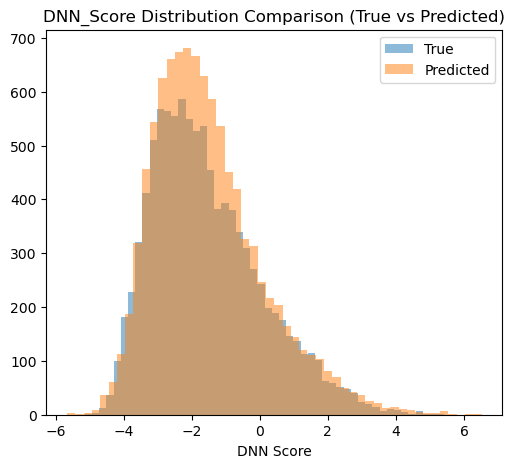

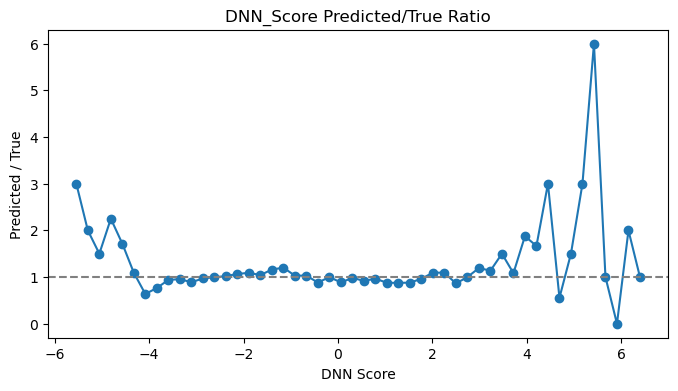

The average ratio across all bins for DNN_score is 1.3228270130870399


In [11]:
# DNN_score distribution
DNN_true_df = np.sort(true_points_pole[['DNN_score']].to_numpy())
DNN_pred_df = np.sort(pred_points_pole[['DNN_score']].to_numpy())


# For plotting the ratios of the histograms
DNN_true_vals = DNN_true_df.ravel()
DNN_pred_vals = DNN_pred_df.ravel()
DNN_num_bins = 50
DNN_bin_edges = np.histogram_bin_edges(np.concatenate([DNN_true_vals, DNN_pred_vals]), bins=DNN_num_bins)
DNN_true_counts = np.histogram(DNN_true_vals, bins=DNN_bin_edges)[0]
DNN_pred_counts = np.histogram(DNN_pred_vals, bins=DNN_bin_edges)[0]
DNN_ratio = DNN_pred_counts / np.maximum(DNN_true_counts, 1) 
# Bin centers for plotting
DNN_bin_centers = 0.5 * (DNN_bin_edges[:-1] + DNN_bin_edges[1:])


plt.figure(1, figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(DNN_true_df, bins=DNN_num_bins, alpha=0.5, label='True')
plt.hist(DNN_pred_df, bins=DNN_num_bins, alpha=0.5, label='Predicted')
plt.xlabel('DNN Score')
plt.title('DNN_Score Distribution Comparison (True vs Predicted)')
plt.legend()
plt.savefig('graphs/DNN_score_comparison.png')

plt.figure(figsize=(8, 4))
plt.plot(DNN_bin_centers, DNN_ratio, marker='o')
plt.axhline(1.0, color='gray', linestyle='--')
plt.xlabel('DNN Score')
plt.ylabel('Predicted / True')
plt.title('DNN_Score Predicted/True Ratio')
plt.savefig('graphs/DNN_score_ratio.png')
plt.show()

print(f"The average ratio across all bins for DNN_score is {np.mean(DNN_ratio)}")

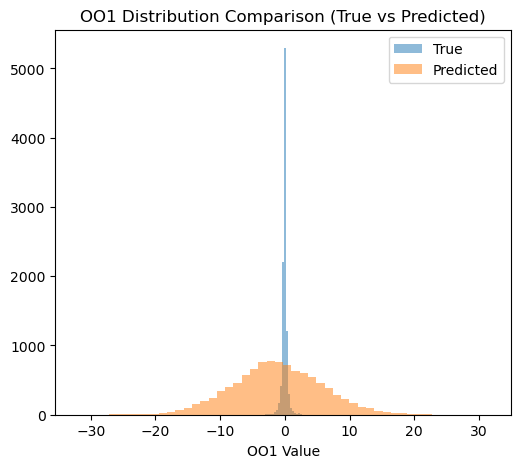

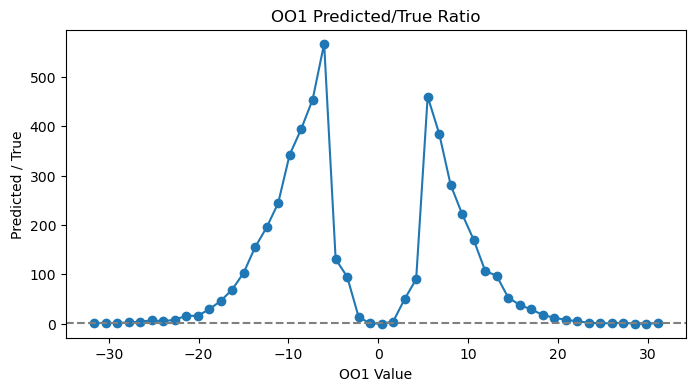

The average ratio across all bins for OO1 is 98.75622787643921


In [12]:
# OO1 distribution
OO1_true_df = np.sort(true_points_pole[['OO1']].to_numpy())
OO1_pred_df = np.sort(pred_points_pole[['OO1']].to_numpy())

# For plotting the ratios of the histograms
OO1_true_vals = OO1_true_df.ravel()
OO1_pred_vals = OO1_pred_df.ravel()
OO1_num_bins = 50
OO1_bin_edges = np.histogram_bin_edges(np.concatenate([OO1_true_vals, OO1_pred_vals]), bins=OO1_num_bins)
OO1_true_counts = np.histogram(OO1_true_vals, bins=OO1_bin_edges)[0]
OO1_pred_counts = np.histogram(OO1_pred_vals, bins=OO1_bin_edges)[0]
OO1_ratio = OO1_pred_counts / np.maximum(OO1_true_counts, 1)
 
# Bin centers for plotting
OO1_bin_centers = 0.5 * (OO1_bin_edges[:-1] + OO1_bin_edges[1:])


plt.figure(1, figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(OO1_true_df, bins=OO1_num_bins, alpha=0.5, label='True')
plt.hist(OO1_pred_df, bins=OO1_num_bins, alpha=0.5, label='Predicted')
plt.xlabel('OO1 Value')
plt.title('OO1 Distribution Comparison (True vs Predicted)')
plt.legend()
plt.savefig('graphs/OO1_comparison.png')

plt.figure(figsize=(8, 4))
plt.plot(OO1_bin_centers, OO1_ratio, marker='o')
plt.axhline(1.0, color='gray', linestyle='--')
plt.xlabel('OO1 Value')
plt.ylabel('Predicted / True')
plt.title('OO1 Predicted/True Ratio')
plt.savefig('graphs/OO1_ratio.png')
plt.show()


print(f"The average ratio across all bins for OO1 is {np.mean(OO1_ratio)}")

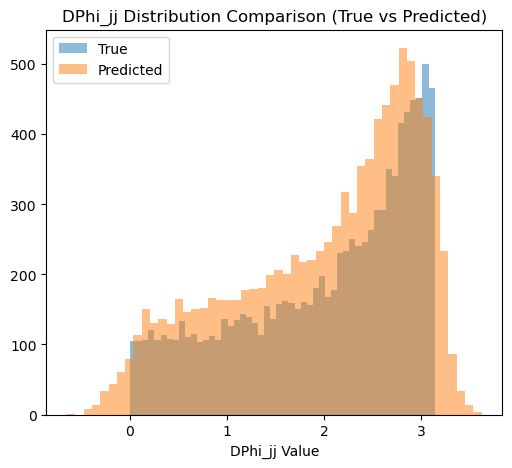

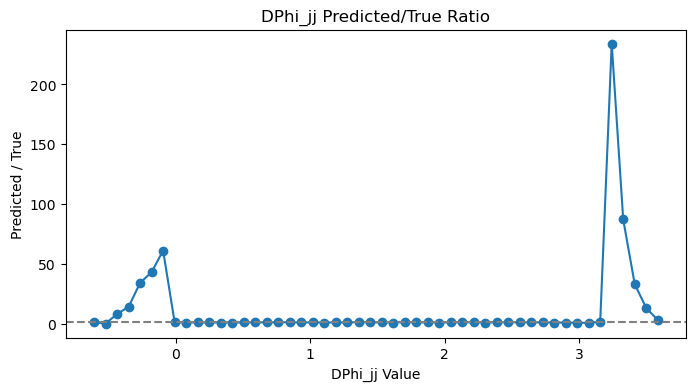

The average ratio across all bins for DPhi_jj is 11.364720563825099


In [13]:
# DPhi_jj distribution
DPhi_true_df = np.sort(true_points_pole[['DPhi_jj']].to_numpy())
DPhi_pred_df = np.sort(pred_points_pole[['DPhi_jj']].to_numpy())

# For plotting the ratios of the histograms
DPhi_true_vals = DPhi_true_df.ravel()
DPhi_pred_vals = DPhi_pred_df.ravel()
DPhi_num_bins = 50
DPhi_bin_edges = np.histogram_bin_edges(np.concatenate([DPhi_true_vals, DPhi_pred_vals]), bins=DPhi_num_bins)
DPhi_true_counts = np.histogram(DPhi_true_vals, bins=DPhi_bin_edges)[0]
DPhi_pred_counts = np.histogram(DPhi_pred_vals, bins=DPhi_bin_edges)[0]
DPhi_ratio = DPhi_pred_counts / np.maximum(DPhi_true_counts, 1) 
# Bin centers for plotting
DPhi_bin_centers = 0.5 * (DPhi_bin_edges[:-1] + DPhi_bin_edges[1:])


plt.figure(1, figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(DPhi_true_df, bins=DPhi_num_bins, alpha=0.5, label='True')
plt.hist(DPhi_pred_df, bins=DPhi_num_bins, alpha=0.5, label='Predicted')
plt.xlabel('DPhi_jj Value')
plt.title('DPhi_jj Distribution Comparison (True vs Predicted)')
plt.legend()
plt.savefig('graphs/DPhi_jj_comparison.png')

plt.figure(figsize=(8, 4))
plt.plot(DPhi_bin_centers, DPhi_ratio, marker='o')
plt.axhline(1.0, color='gray', linestyle='--')
plt.xlabel('DPhi_jj Value')
plt.ylabel('Predicted / True')
plt.title('DPhi_jj Predicted/True Ratio')
plt.savefig('graphs/DPhi_jj_ratio.png')
plt.show()

print(f"The average ratio across all bins for DPhi_jj is {np.mean(DPhi_ratio)}")